In [1]:
import scvelo as scv
import scanpy as sc
import scFates as scf
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import palantir
from cuml import UMAP
%matplotlib inline
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo',figsize=(5,5),dpi_save=600)

In [2]:
from caching_wrappers import * 
name="Bif_SA_GutGlia"

In [3]:
import pandas as pd
auc=pd.read_csv("scenic/output/auc_mtx_mm10.csv",index_col=0)

In [4]:
def reprocess(adata,root,leaves):
    
    path=scf.tools.getpath(adata,root_milestone=root,milestones=leaves)
    path=path[~path.index.duplicated(keep='first')]
    import numpy as np

    colkeep=list(map(lambda m: adata.uns["milestones_colors"][np.argwhere(adata.obs.milestones.cat.categories==m)[0][0]],
         path.milestones.unique()))
    
    adata=adata[path.index,]
    dm_res = palantir.utils.run_diffusion_maps(auc.loc[path.index,:],knn=100)
    ms_data = palantir.utils.determine_multiscale_space(dm_res)
    umap = UMAP(n_components = 2,n_neighbors=150,min_dist=.4,n_epochs=2000,random_state=1)
    emb = umap.fit_transform(ms_data.values)
    plt.figure(figsize=(10,10))
    plt.scatter(emb[:,0],emb[:,1],c=adata.obs.t[ms_data.index],s=10,cmap="viridis")
    plt.axis("off")
    plt.tight_layout()
    adata.obsm["X_umap2"] = adata.obsm["X_umap"]
    adata.obsm["X_umap"] = emb
    
    del adata.uns
    
    adata.obs["old_milestones"] = adata.obs["milestones"]
    adata.obs.old_milestones=adata.obs.old_milestones.cat.reorder_categories(path.milestones.unique())
    adata.uns["old_milestones_colors"] = colkeep
    
    return adata

In [5]:
adata=sc.read("adata_tree_fpm.h5ad")

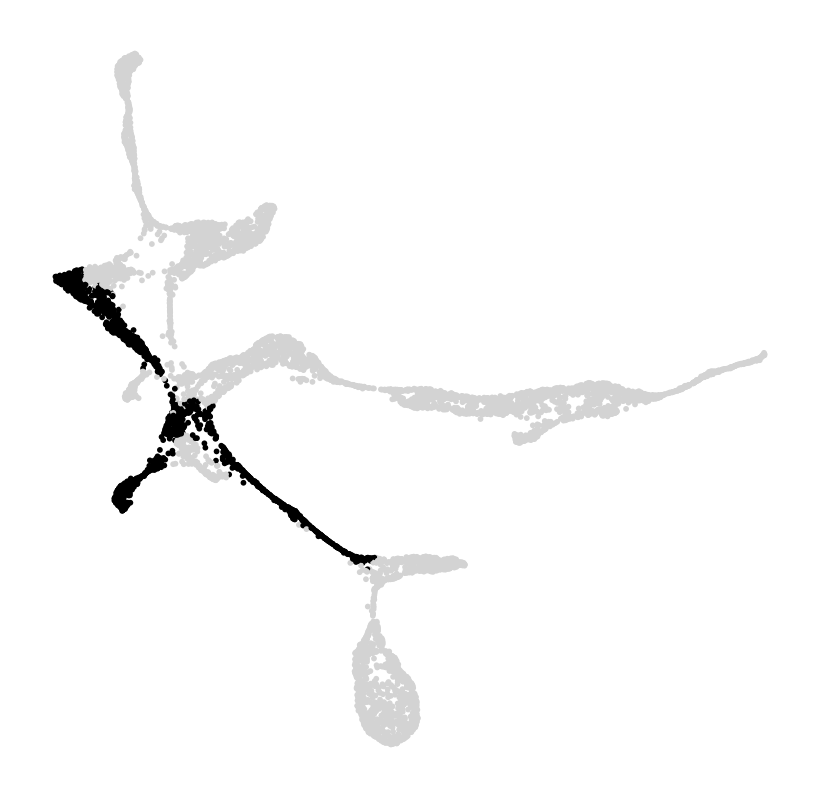

In [6]:
path=scf.tools.getpath(adata,"ecaNCC",["Gut_glia","bi_ChC_Symp"])
path=path[~path.index.duplicated(keep='first')]
adata.obs["sel"]=adata.obs_names.isin(path.index)
adata.obs["sel"]=adata.obs["sel"].astype("category")
sc.pl.umap(adata,color="sel",palette=["lightgrey","black"],frameon=False,legend_loc="none",title="",
           save="-Bif_SA_Glia.png")

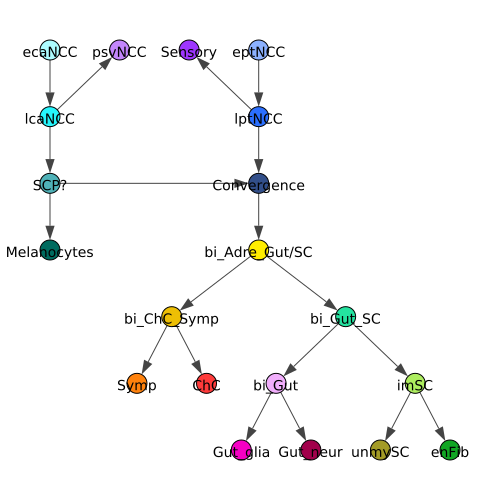

In [7]:
scf.pl.milestones(adata,roots=["ecaNCC","eptNCC","Sensory","psvNCC"])

Determing nearest neighbor graph...


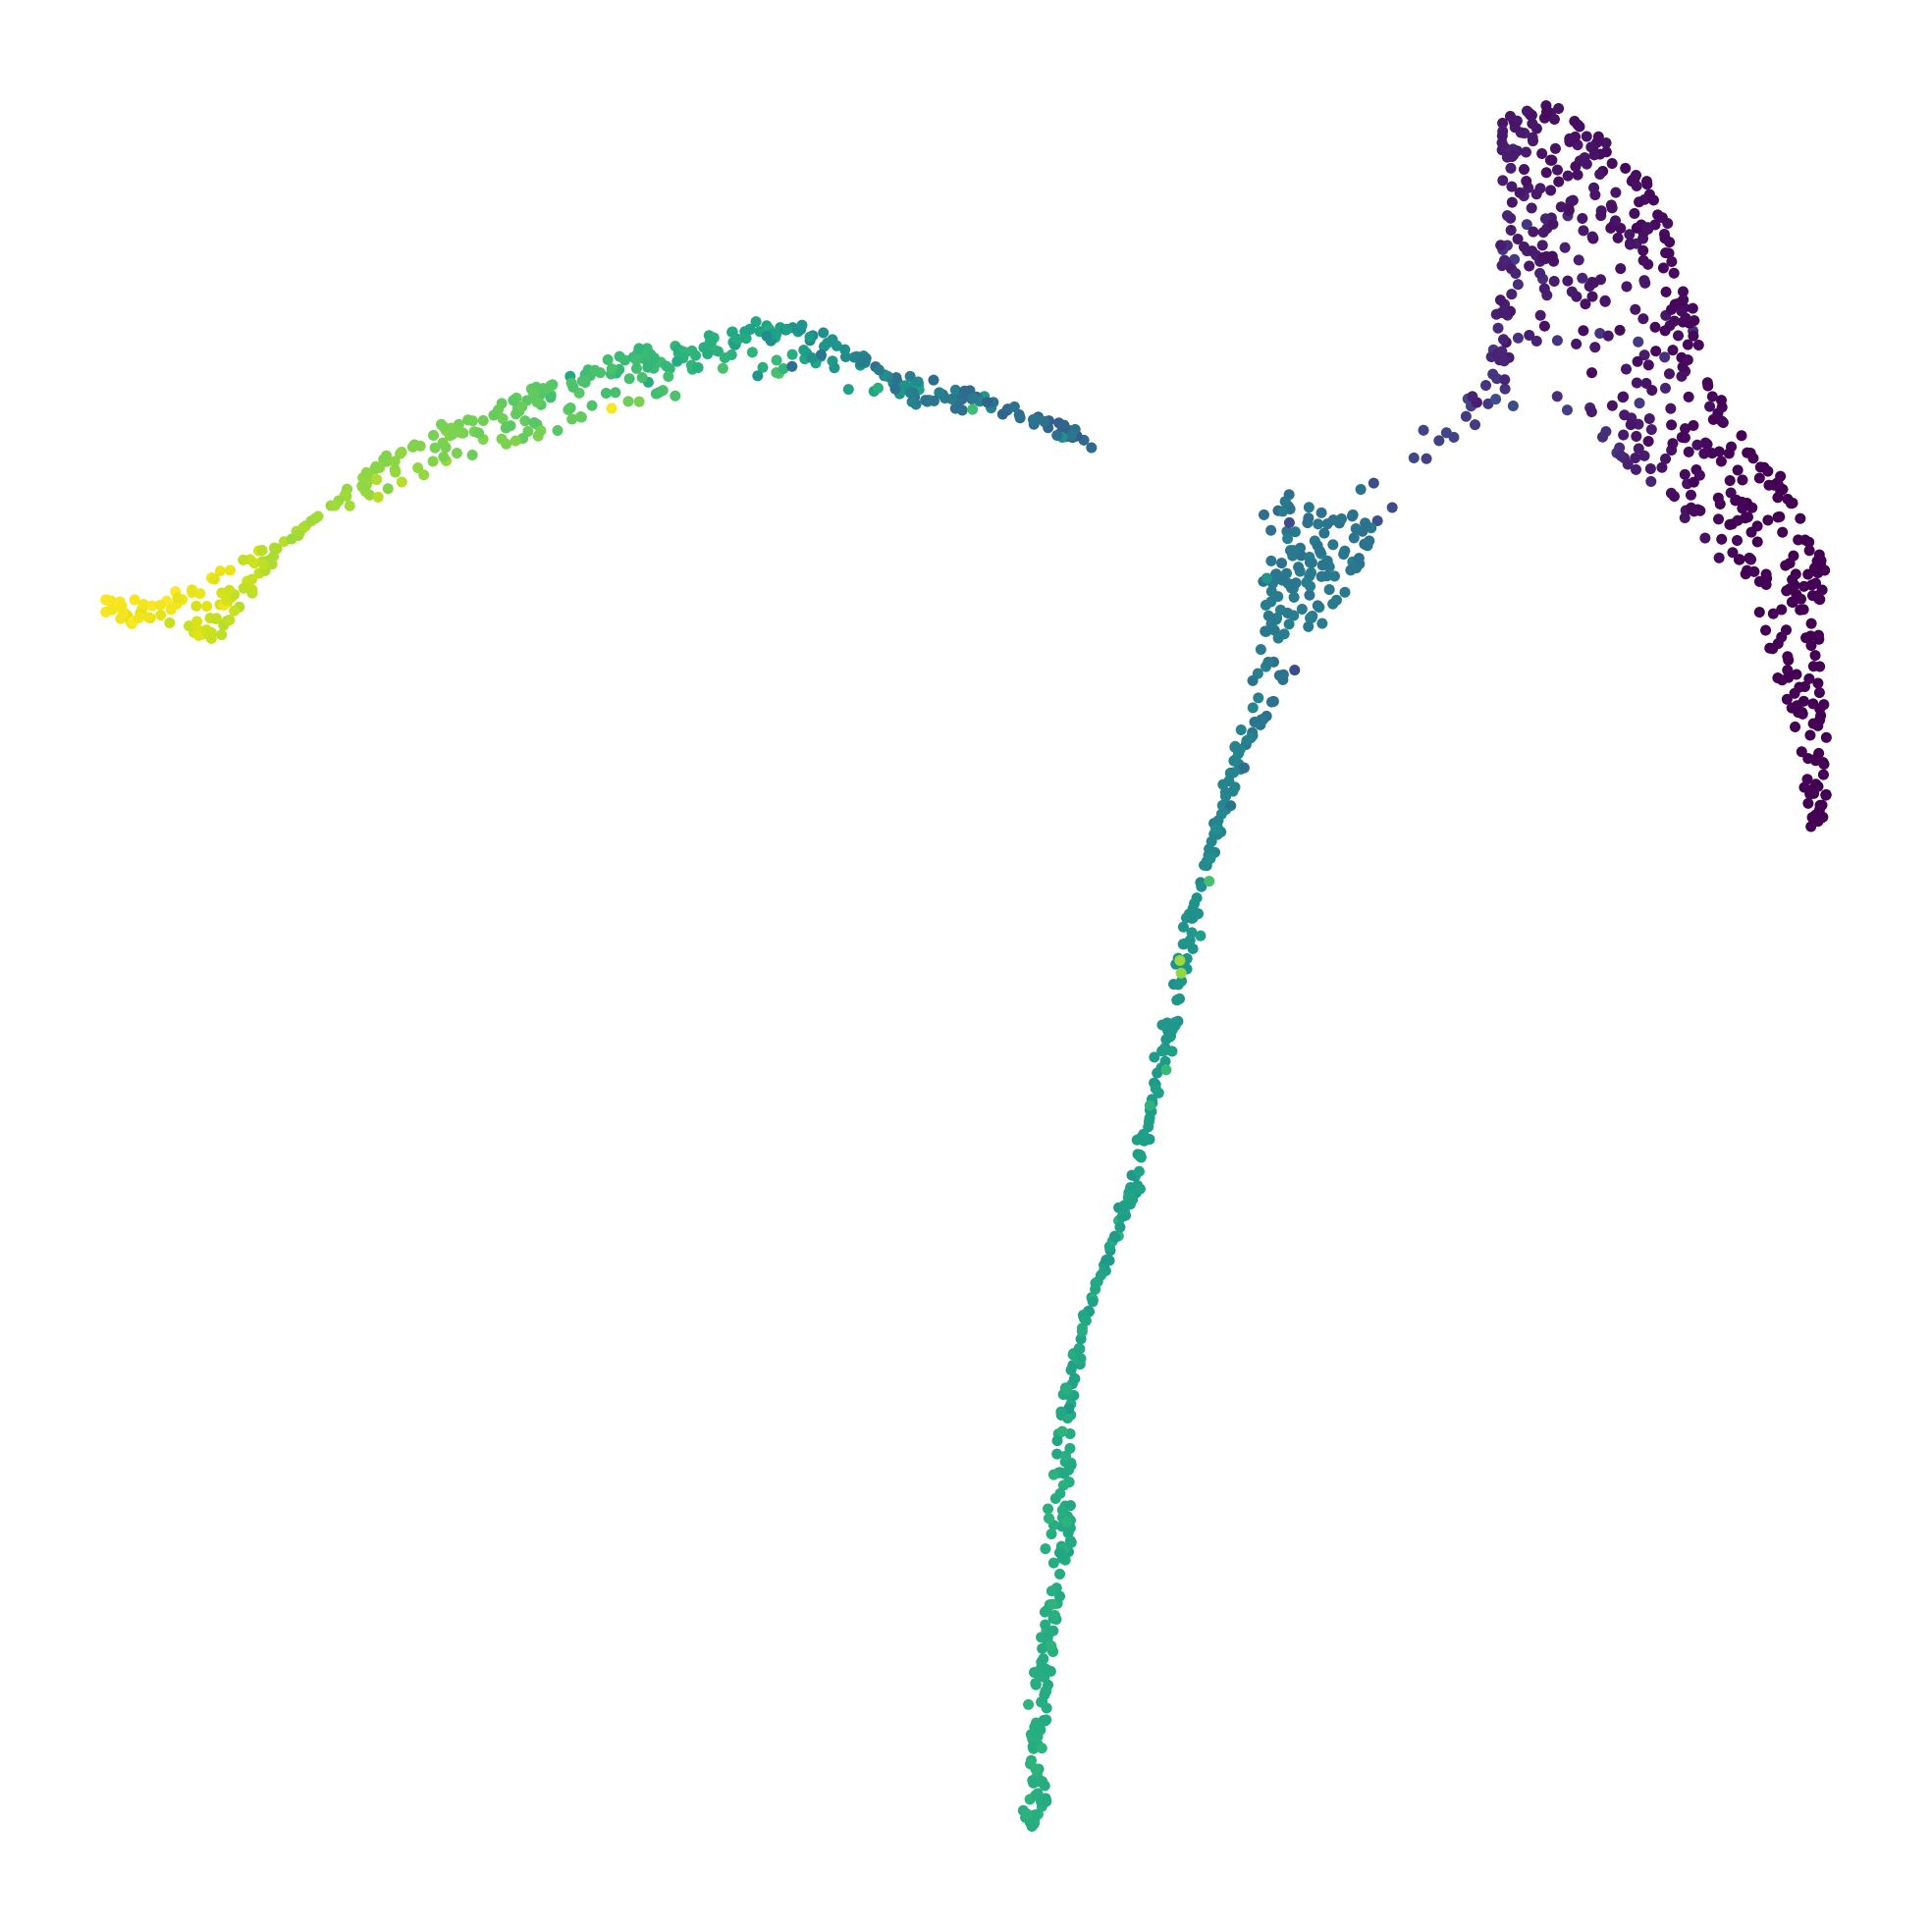

In [8]:
adata=reprocess(adata,"ecaNCC",["Gut_glia","bi_ChC_Symp"])

In [9]:
adata.obsm["X_diffusion"]=adata.obsm["X_diffusion"][:,:2]

In [10]:
c.tl.tree(adata,Nodes=500,ppt_err_cut=0.01,
            use_rep="diffusion",ppt_sigma = 0.1,ppt_lambda=100,ppt_nsteps=100,
            method="ppt",device="gpu",seed=1,fname=name+'-tree')

No cache found in `Bif_SA_GutGlia-tree.pickle`, computing values.
inferring a principal tree --> parameters used 
    500 principal points, sigma = 0.1, lambda = 100
    fitting:  34%|███▍      | 34/100 [00:01<00:03, 21.29it/s]
    converged
    finished (0:00:01) --> added 
    'ppt', dictionnary containing inferred tree (adata.uns)
    'tree/B', adjacency matrix of the principal points (adata.uns)
    'tree/R', soft assignment of cells to principal point in representation space (adata.uns)
    'tree/F', coordinates of principal points in representation space (adata.uns)


    tree cleaned --> removed 0 principal points


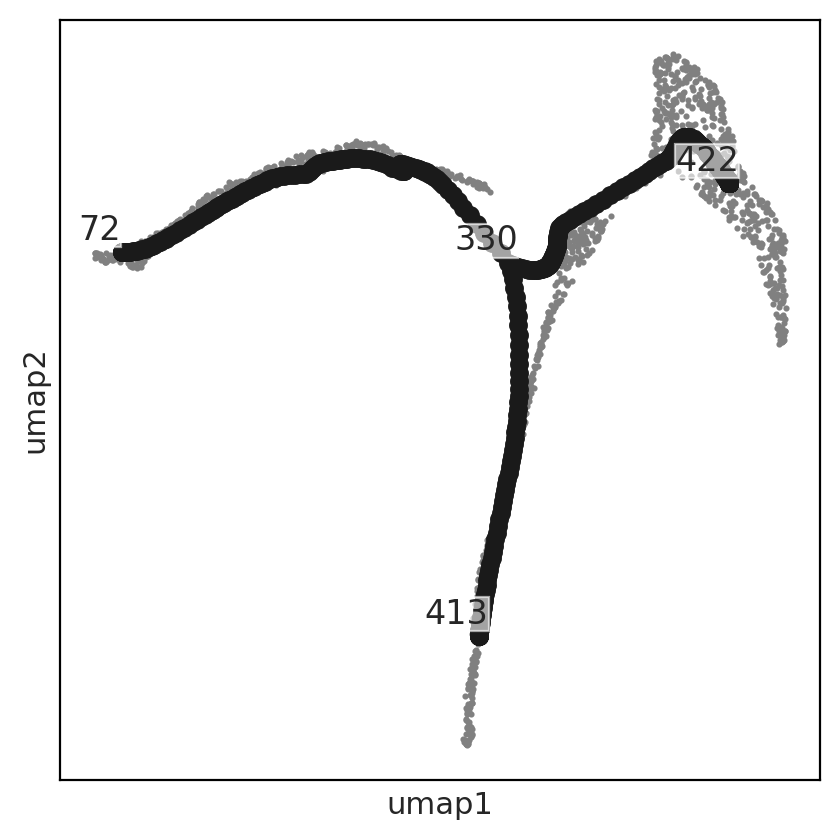

In [11]:
scf.tl.cleanup(adata,minbranchlength=30)
scf.pl.tree(adata)

In [12]:
scf.tl.root(adata,422)

root selected --> added
    'tree/root', selected root (adata.uns)
    'tree/pp_info', for each PP, its distance vs root and segment assignment (adata.uns)
    'tree/pp_seg', segments network information (adata.uns)


In [13]:
scf.tl.pseudotime(adata)

projecting cells onto the principal tree
    finished (0:00:01) --> added
    'edge', assigned edge (adata.obs)
    't', pseudotime value (adata.obs)
    'seg', segment of the tree where the cell is assigned to (adata.obs)
    'milestones', milestones assigned to (adata.obs)
    'pseudotime_list', list of cell projection from all mappings (adata.uns)


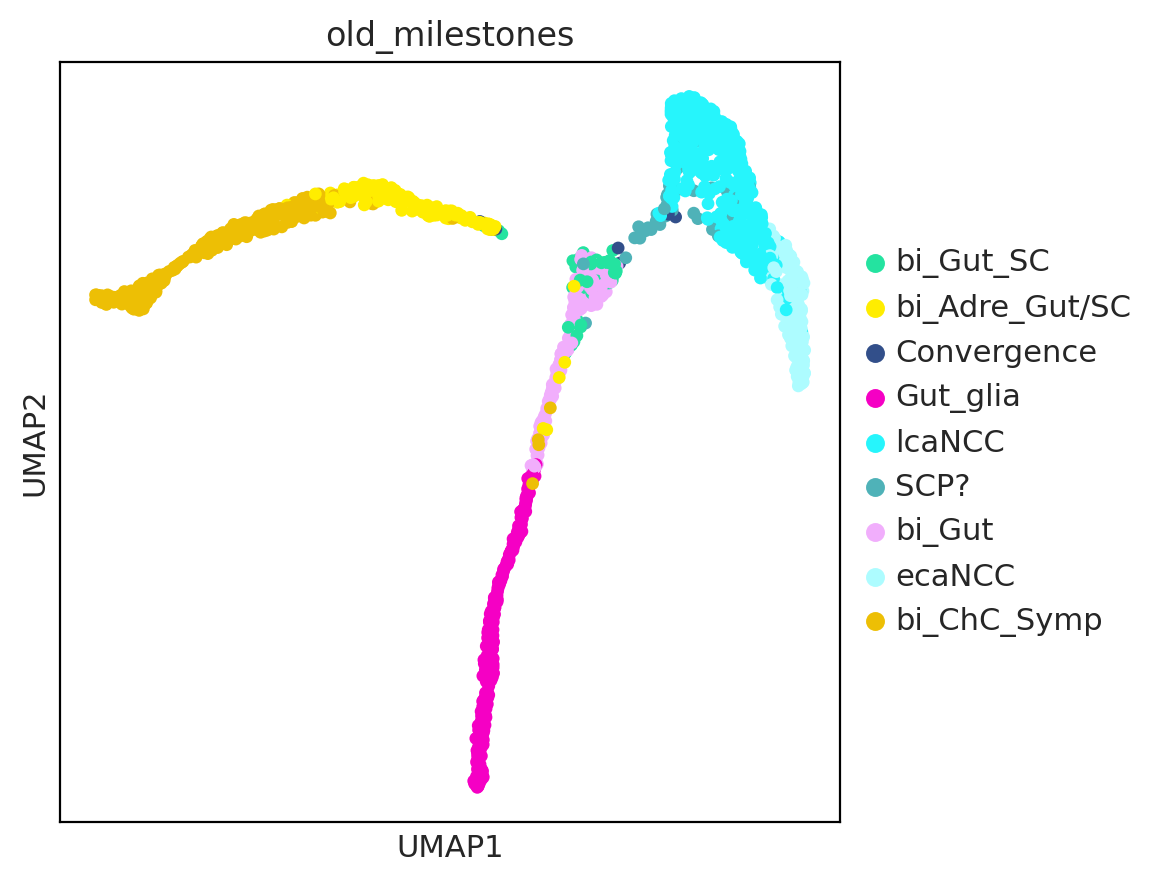

In [14]:
sc.pl.umap(adata,color="old_milestones")

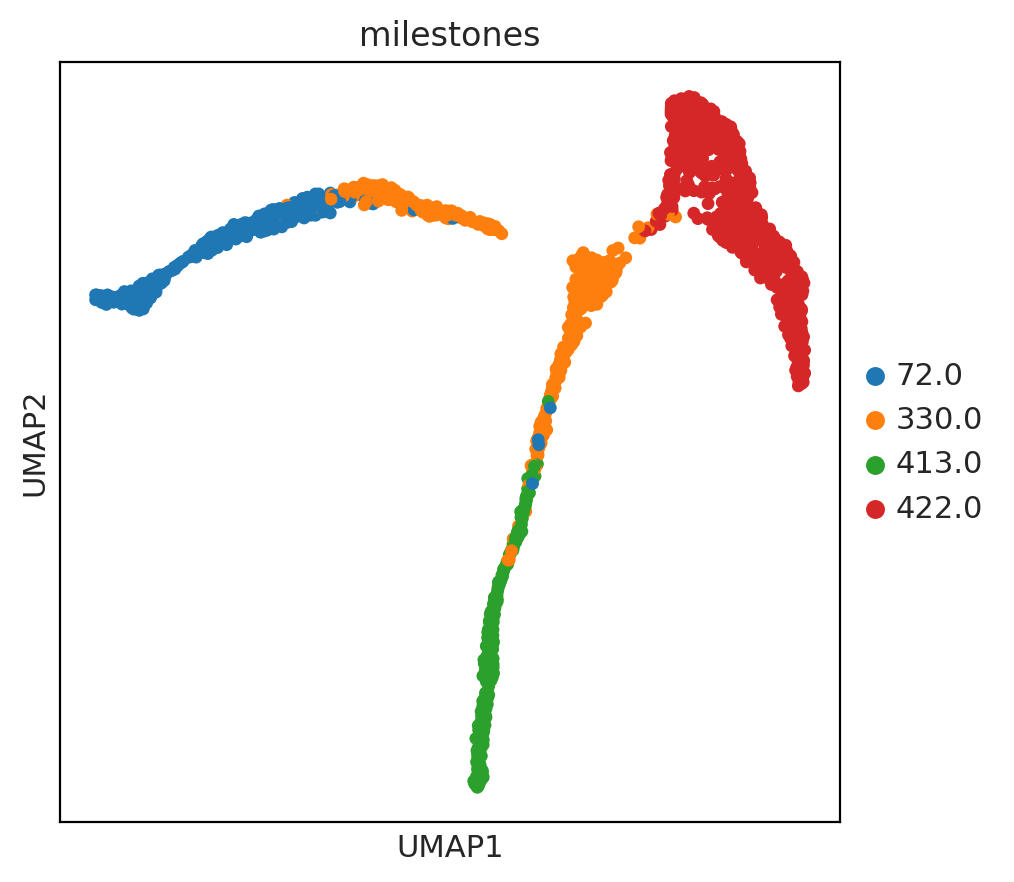

In [15]:
sc.pl.umap(adata,color="milestones")



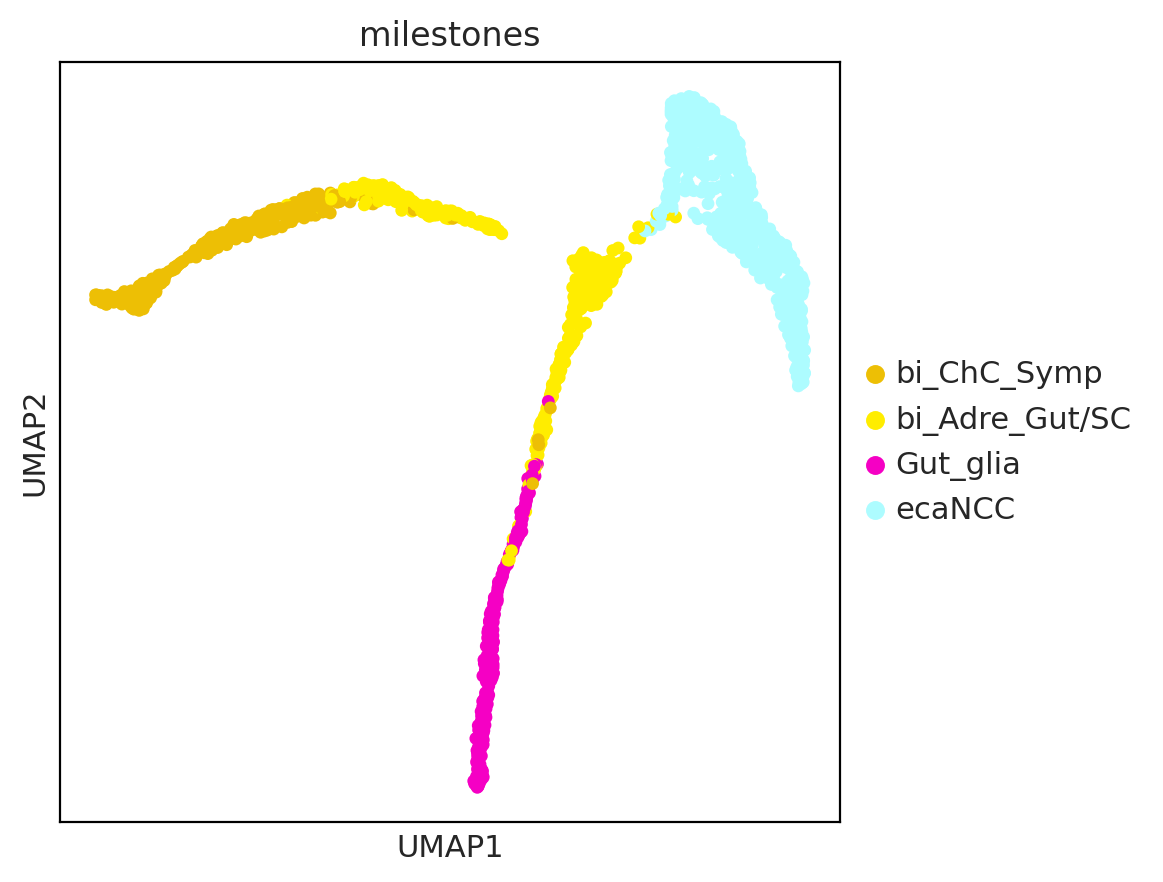

In [16]:
mil=["bi_ChC_Symp","bi_Adre_Gut/SC","Gut_glia","ecaNCC"]
adata.obs.milestones=adata.obs.milestones.cat.rename_categories(mil)
dct=dict(zip(adata.obs.old_milestones.cat.categories,adata.uns["old_milestones_colors"]))
adata.uns["milestones_colors"]=[dct[idx] for idx in adata.obs.milestones.cat.categories]
sc.pl.umap(adata,color="milestones")

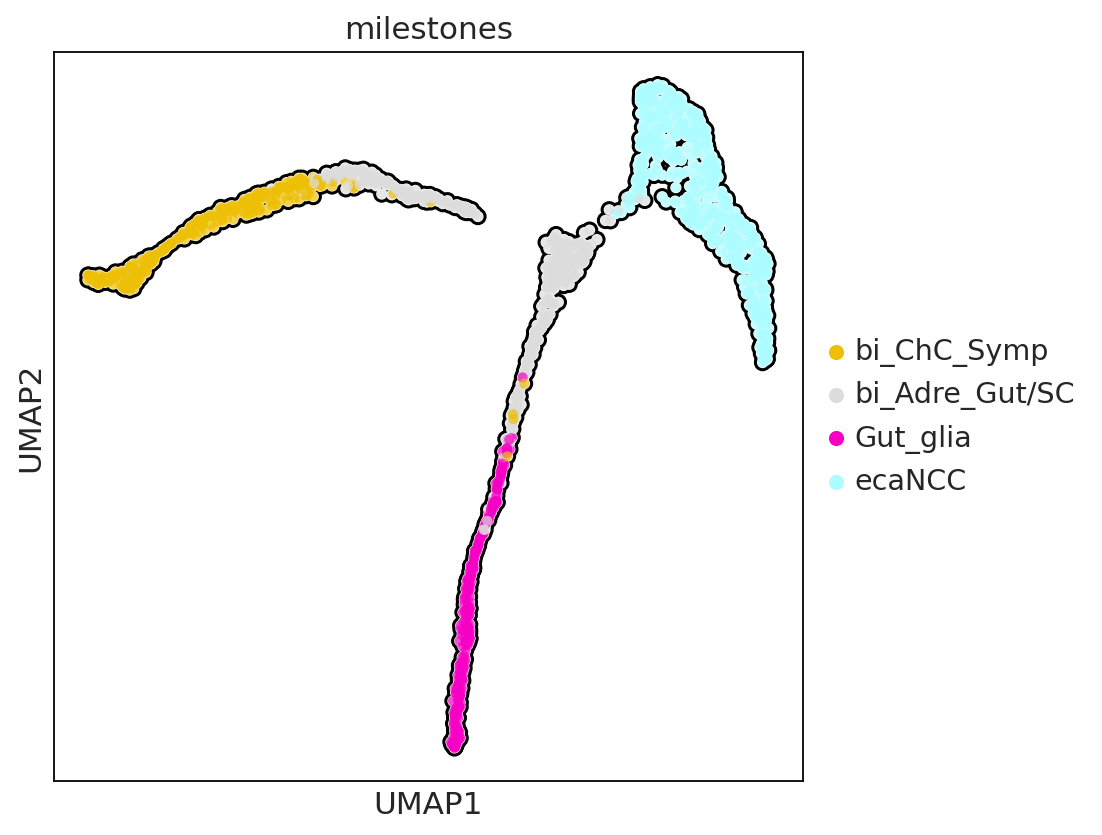

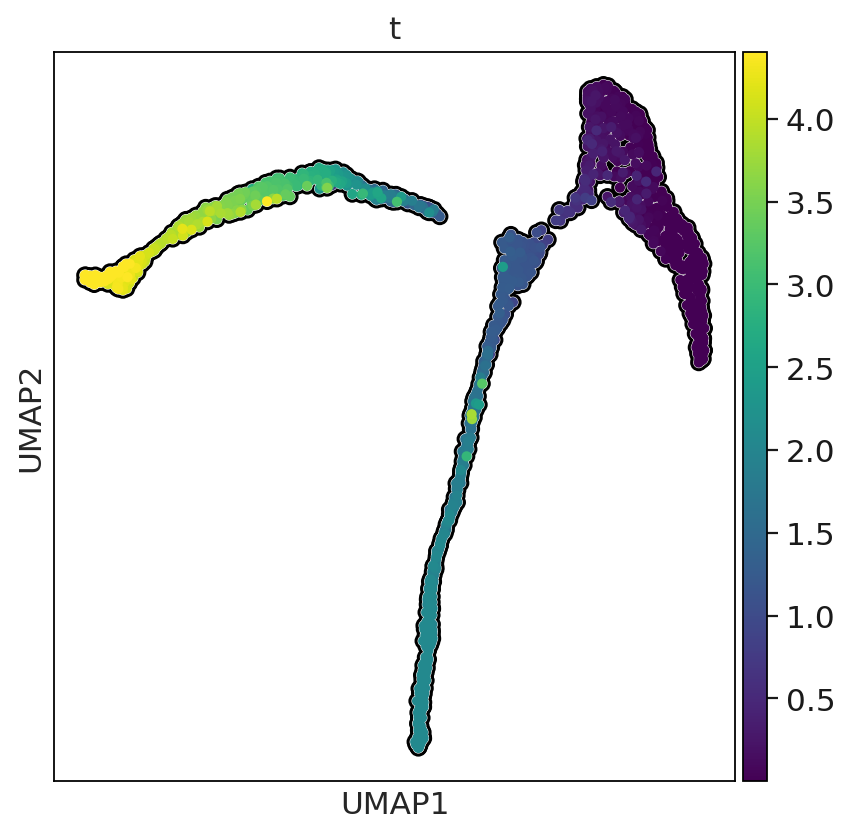

In [17]:
adata.uns["milestones_colors"][1]="#DCDCDC"
sc.set_figure_params(figsize=(6,6),dpi_save=600)
sc.pl.umap(adata,color="milestones",add_outline=True,save="milestones-Bif_SA_Glia.png")
sc.pl.umap(adata,color="t",add_outline=True,color_map="viridis",alpha=1,save="pseudotime-Bif_SA_Glia.png")

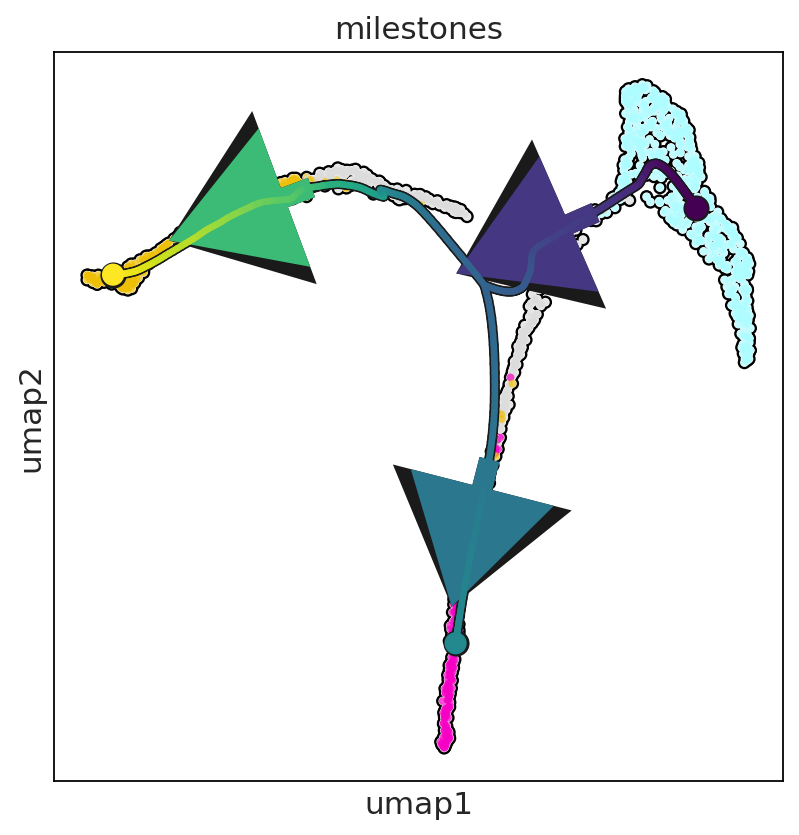

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sc.pl.umap(adata,color="milestones",show=False,legend_loc="none",add_outline=True,ax=ax,size=50)
scf.pl.trajectory(adata,arrows=True,scale_path=0.6,alpha_cells=0,ax=ax,
                  save="-Bif_SA_Glia.png")

No cache found in `Bif_SA_GutGlia-test_association.pickle`, computing values.
test features for association with the tree
    mapping 0: 100%|██████████| 20074/20074 [02:21<00:00, 142.26it/s]
    found 5789 significant features (0:02:21) --> added
    'p_val' values from statistical test (adata.var)
    'fdr' corrected values from multiple testing (adata.var)
    'st' proportion of mapping in which feature is significant (adata.var)
    'A' amplitue of change of tested feature (adata.var)
    'signi' feature is significantly changing along pseuodtime (adata.var)
    'stat_assoc_list', list of fitted features on the tree for all mappings (adata.uns)


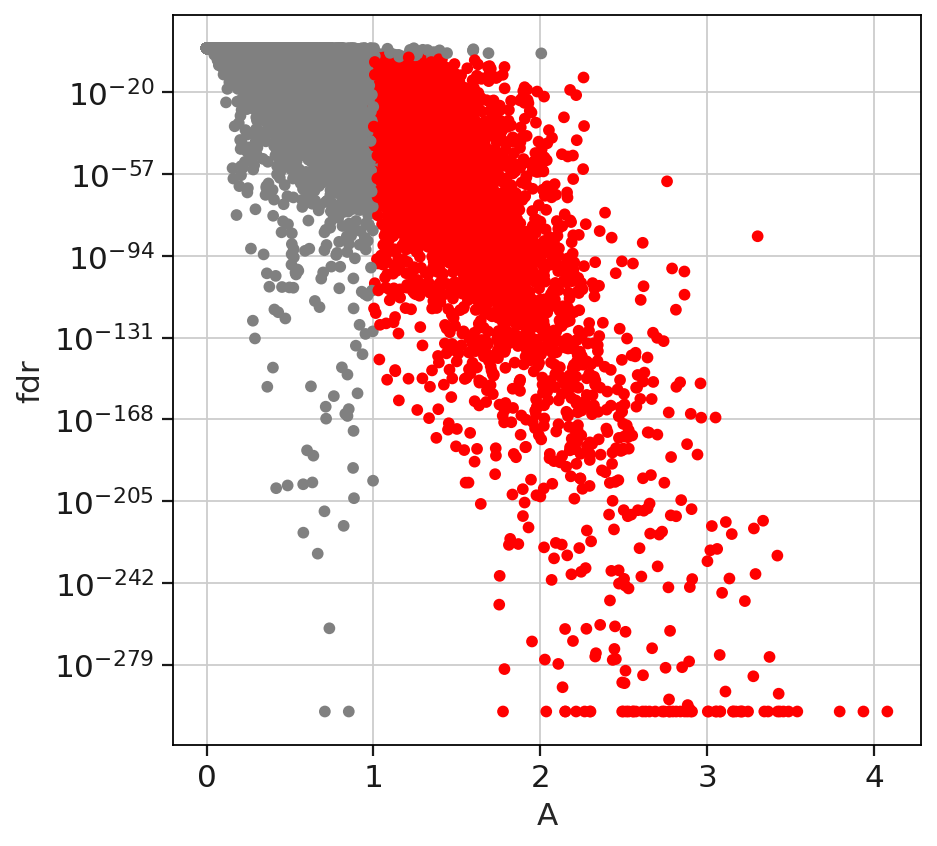

In [19]:
c.tl.test_association(adata,n_jobs=20,fname=name+'-test_association')
scf.pl.test_association(adata)

In [20]:
import os.path
if os.path.isfile("temp/tl/"+name+"-fit.h5ad"):
    adata=sc.read("temp/tl/"+name+"-fit.h5ad")
else:
    scf.tl.fit(adata,n_jobs=40)
    adata.write("temp/tl/"+name+"-fit.h5ad")

fit features associated with the tree
    mapping 0: 100%|██████████| 5789/5789 [00:55<00:00, 103.95it/s]
    finished (adata subsetted to keep only fitted features!) (0:01:00) --> added
    'fitted', fitted features on the tree for all mappings (adata.layers)


In [21]:
root_mil="ecaNCC"
miles = ["Gut_glia","bi_ChC_Symp"]

In [22]:
c.tl.test_fork(adata,root_milestone=root_mil,milestones=miles,n_jobs=40,rescale=True,
               fname=name+"-test_fork")

No cache found in `Bif_SA_GutGlia-test_fork.pickle`, computing values.
testing fork
    mapping: 0
    differential expression: 100%|██████████| 5789/5789 [00:12<00:00, 478.83it/s]
    test for upregulation for each leave vs root
    leave bi_ChC_Symp: 100%|██████████| 5789/5789 [00:08<00:00, 691.21it/s]
    finished (0:00:27) --> added 
    'ecaNCC->Gut_glia<>bi_ChC_Symp/fork', DataFrame with fork test results (adata.uns)


In [23]:
scf.tl.branch_specific(adata,root_milestone=root_mil,milestones=miles,
                       effect_b1=1,effect_b2=1.5)

    100 features found to be specific to leave Gut_glia
    116 features found to be specific to leave bi_ChC_Symp
    finished --> updated 
    'ecaNCC->Gut_glia<>bi_ChC_Symp/fork', DataFrame updated with additionnal 'branch' column (adata.uns)


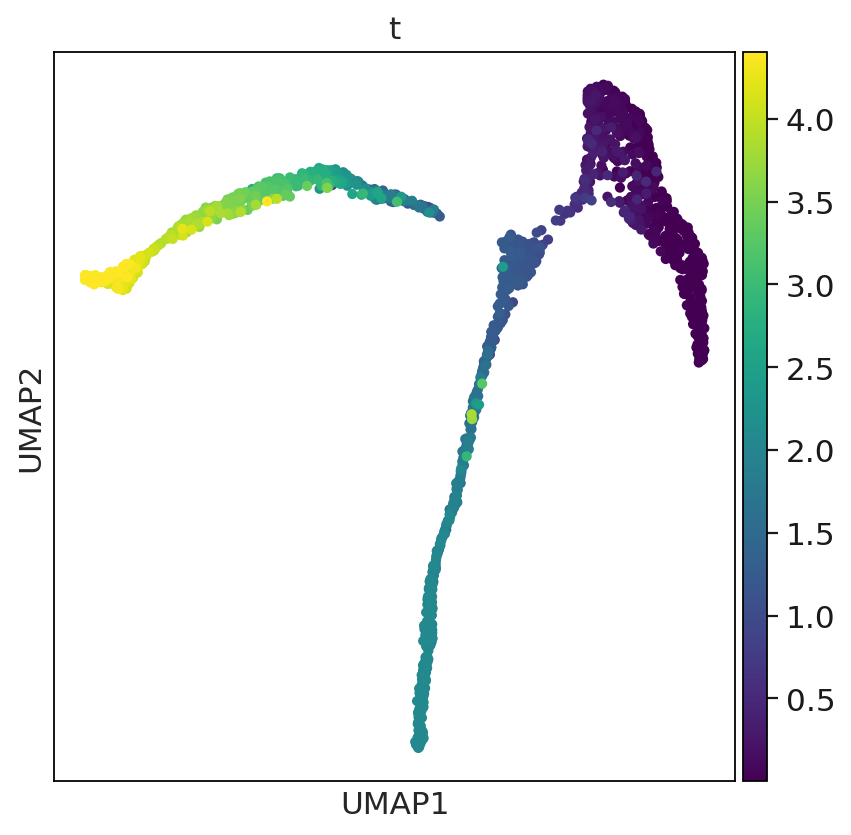

In [24]:
sc.pl.umap(adata,color="t",color_map="viridis")

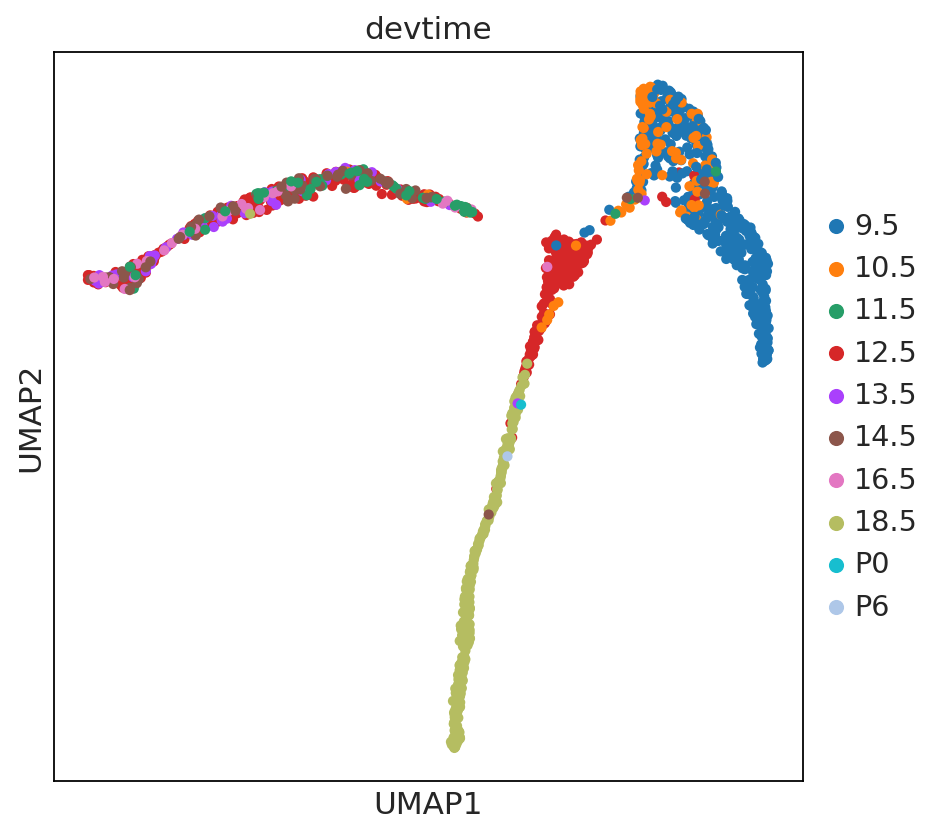

In [25]:
sc.pl.umap(adata,color="devtime",color_map="viridis")

In [26]:
scf.tl.activation(adata,root_milestone=root_mil,milestones=miles,n_jobs=20,pseudotime_offset=0.5,deriv_cut=.2)

testing activation
    leave bi_ChC_Symp: 100%|██████████| 116/116 [00:00<00:00, 329.97it/s]
    49 early and 51 late features specific to leave Gut_glia
    14 early and 102 late features specific to leave bi_ChC_Symp
    finished (0:00:19) --> updated 
    'ecaNCC->Gut_glia<>bi_ChC_Symp/fork', DataFrame updated with additionnal 'activation' and 'module' columns (adata.uns)


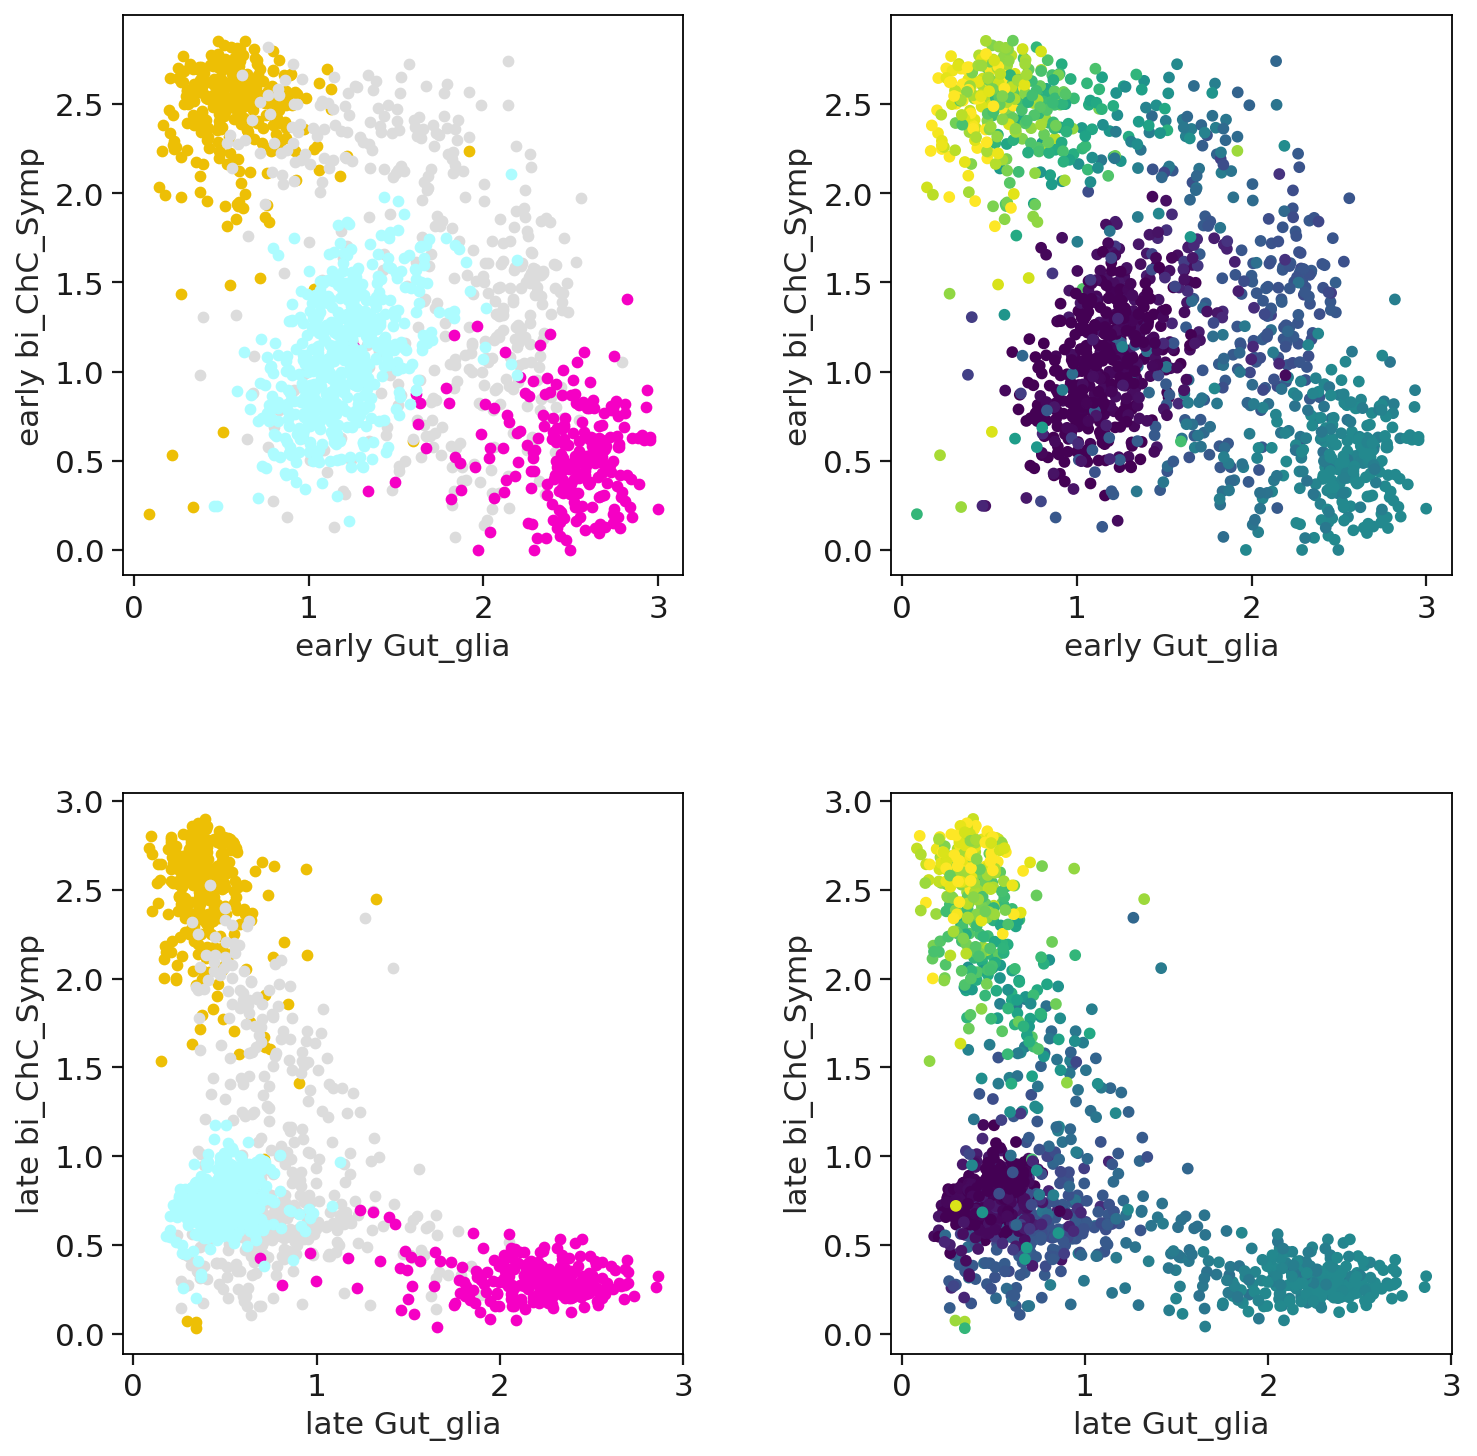

In [27]:
scf.pl.modules(adata,root_milestone=root_mil,milestones=miles,color="milestones",
              save="-Bif_SA_Glia.png")

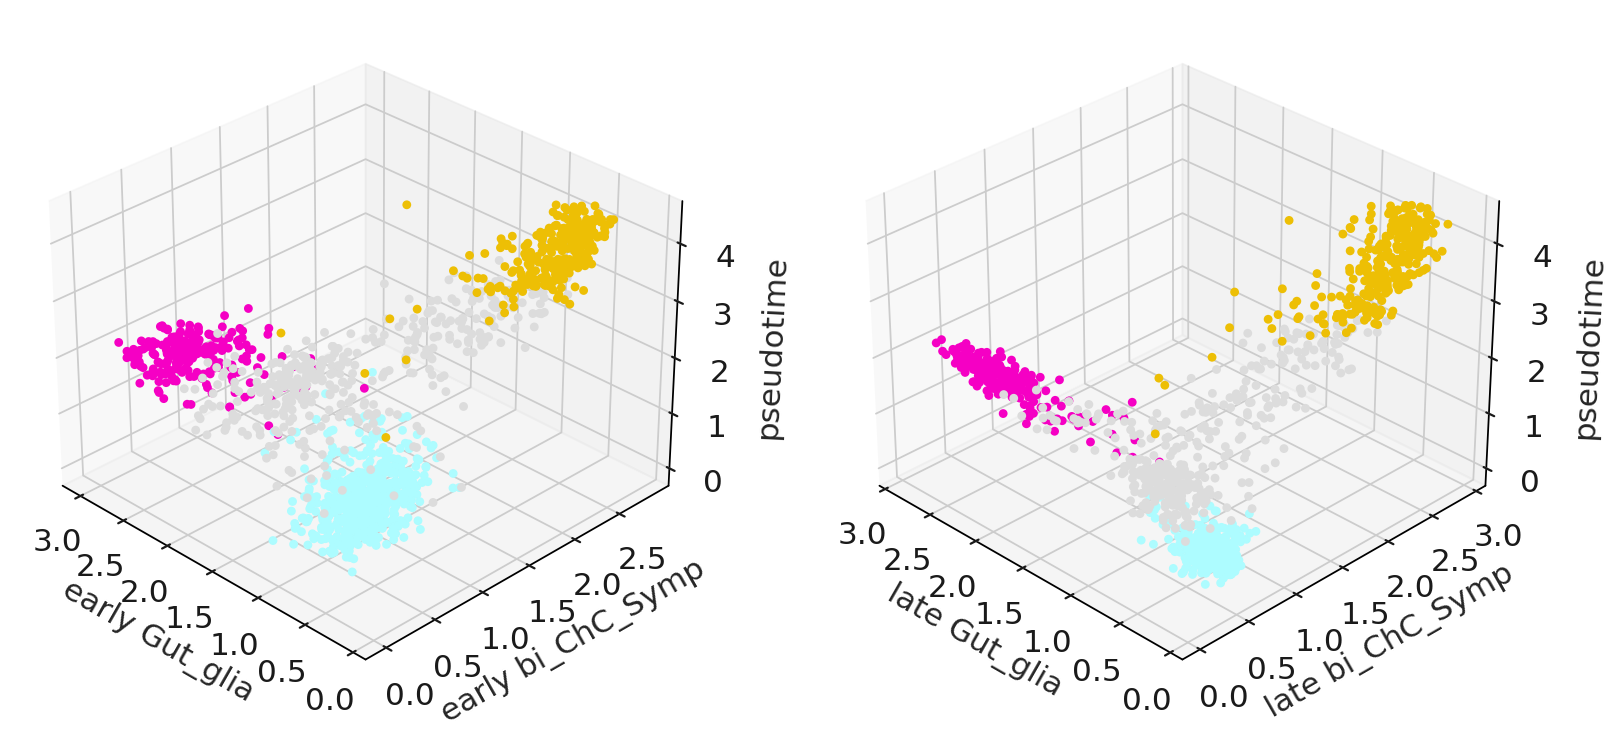

In [28]:
scf.pl.modules(adata,root_milestone=root_mil,milestones=miles,color="milestones",mode="3d")

In [29]:
df=adata.uns['ecaNCC->Gut_glia<>bi_ChC_Symp']['fork']

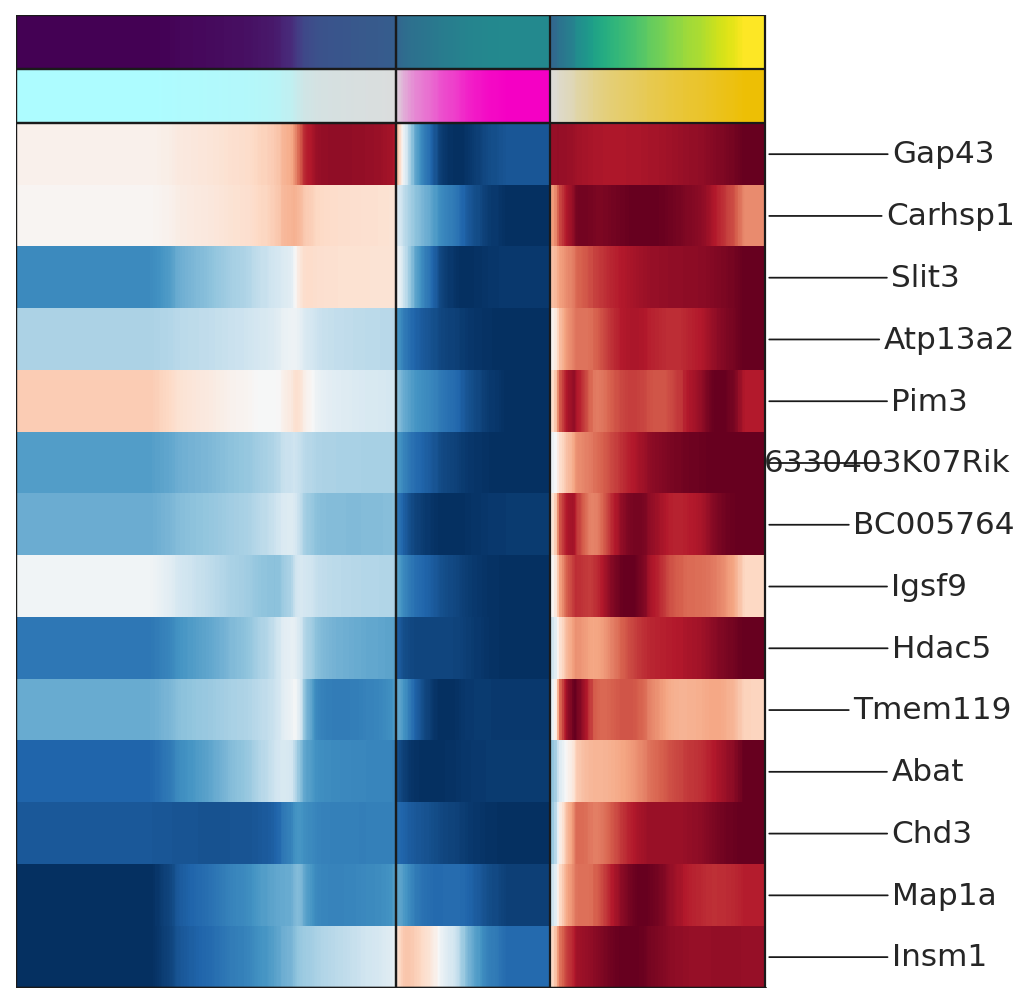

In [31]:
scf.pl.trends(adata,features=df.index[(df.module=="early") & (df.branch==miles[1])],
                    filter_complex=False,ordering="pearson",n_features=14,
                    save="-early_SA(Gutglia).png")

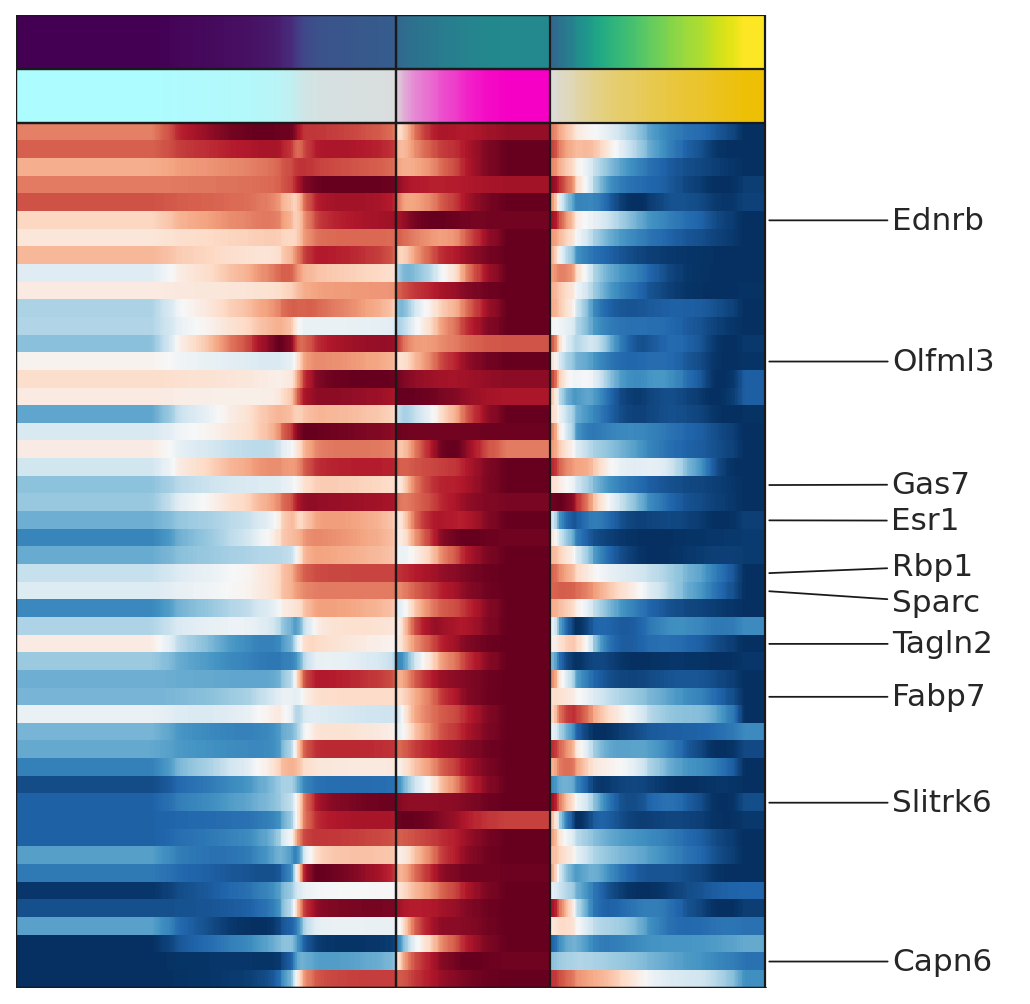

In [32]:
scf.pl.trends(adata,features=df.index[(df.module=="early") & (df.branch==miles[0])],
                    filter_complex=False,ordering="pearson",
                     save="-early_Gutglia(SA).png")

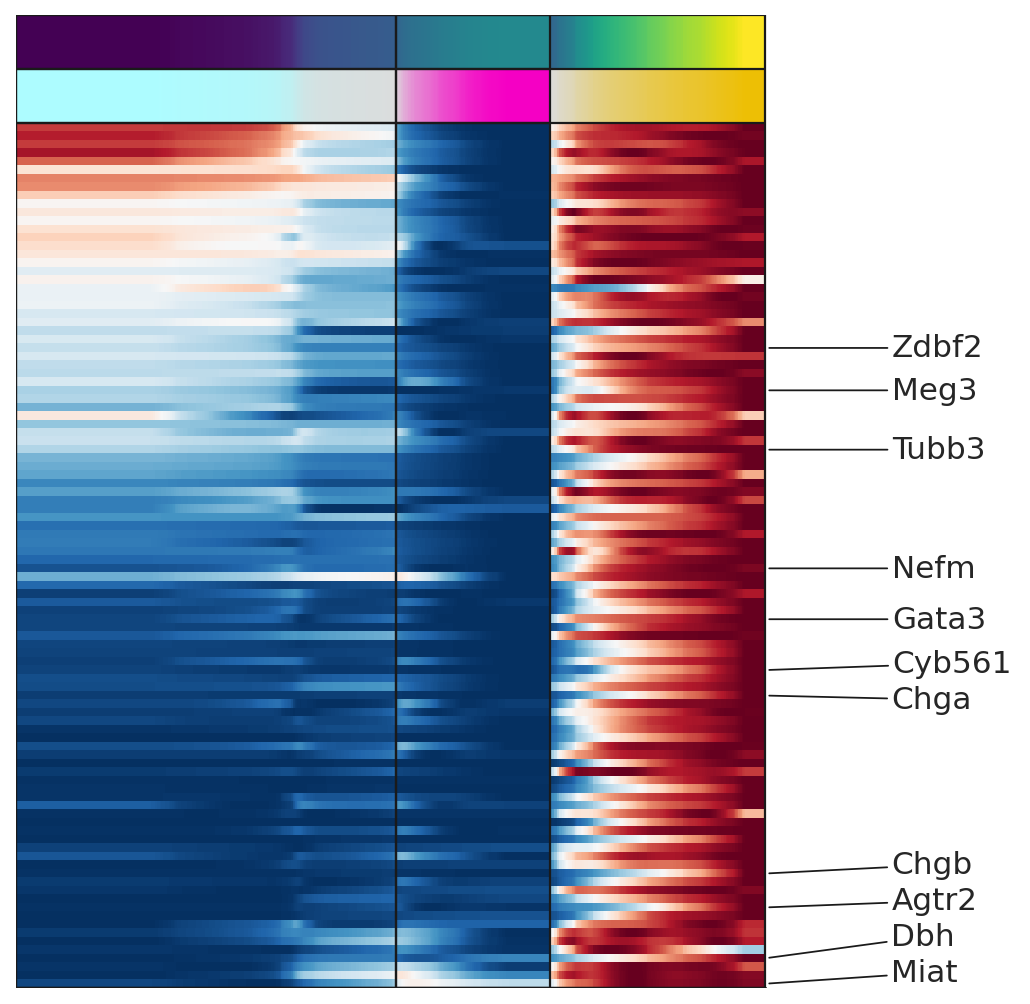

In [33]:
scf.pl.trends(adata,features=df.index[(df.module=="late") & (df.branch==miles[1])],
                    filter_complex=False,ordering="pearson",n_features=11,
                    save="-late_SA(Gutglia).png")

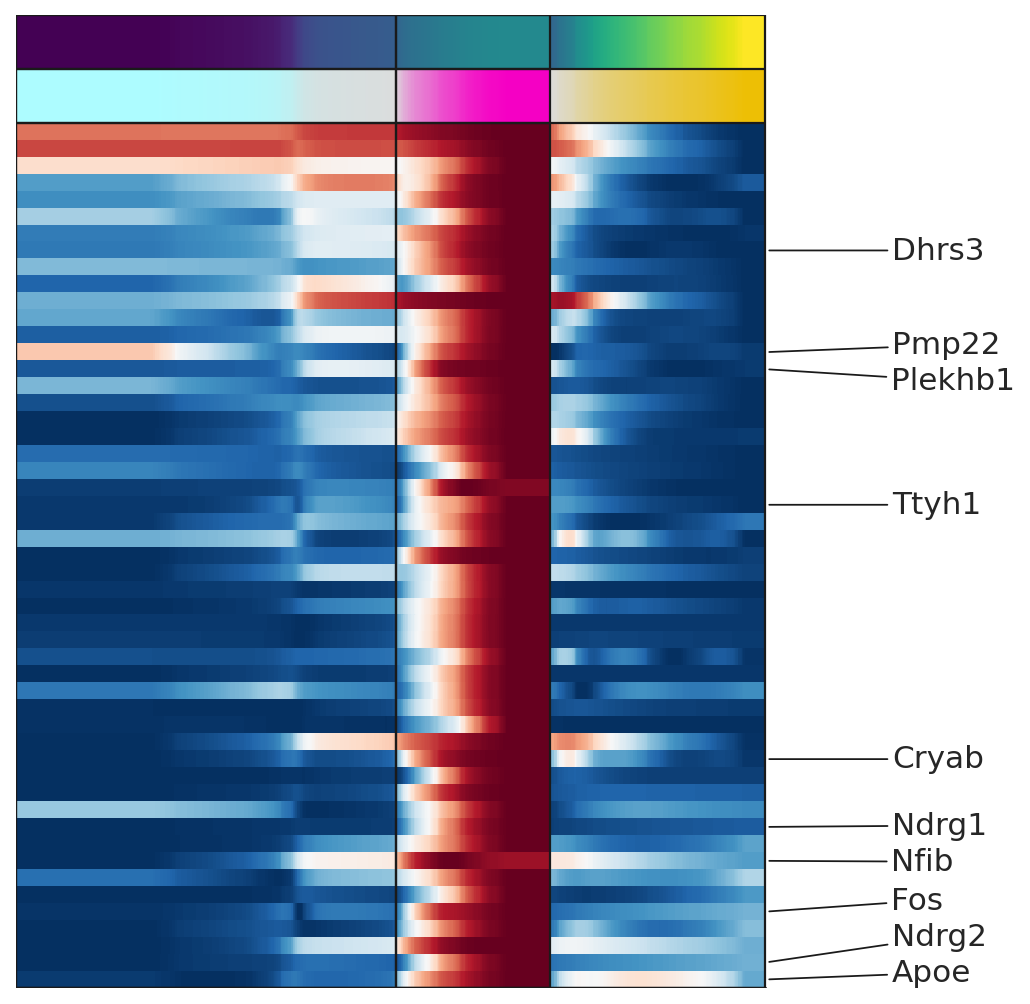

In [34]:
scf.pl.trends(adata,features=df.index[(df.module=="late") & (df.branch==miles[0])],
                    filter_complex=False,ordering="pearson",
                     save="-late_Gutglia(SA).png")

In [35]:
adata.uns['ecaNCC->Gut_glia<>bi_ChC_Symp']['fork'].to_csv("ecaNCC->Gut_glia<>bi_ChC_Symp.csv")

In [36]:
scf.tl.slide_cells(adata,root_milestone=root_mil,milestones=miles,win=100)

--> added 
    'ecaNCC->Gut_glia<>bi_ChC_Symp/cell_freq', probability assignment of cells on 15 non intersecting windows (adata.uns)


In [37]:
scf.tl.slide_cors(adata,root_milestone=root_mil,milestones=miles)

--> added 
    'ecaNCC->Gut_glia<>bi_ChC_Symp/corAB', gene-gene correlation modules (adata.uns)


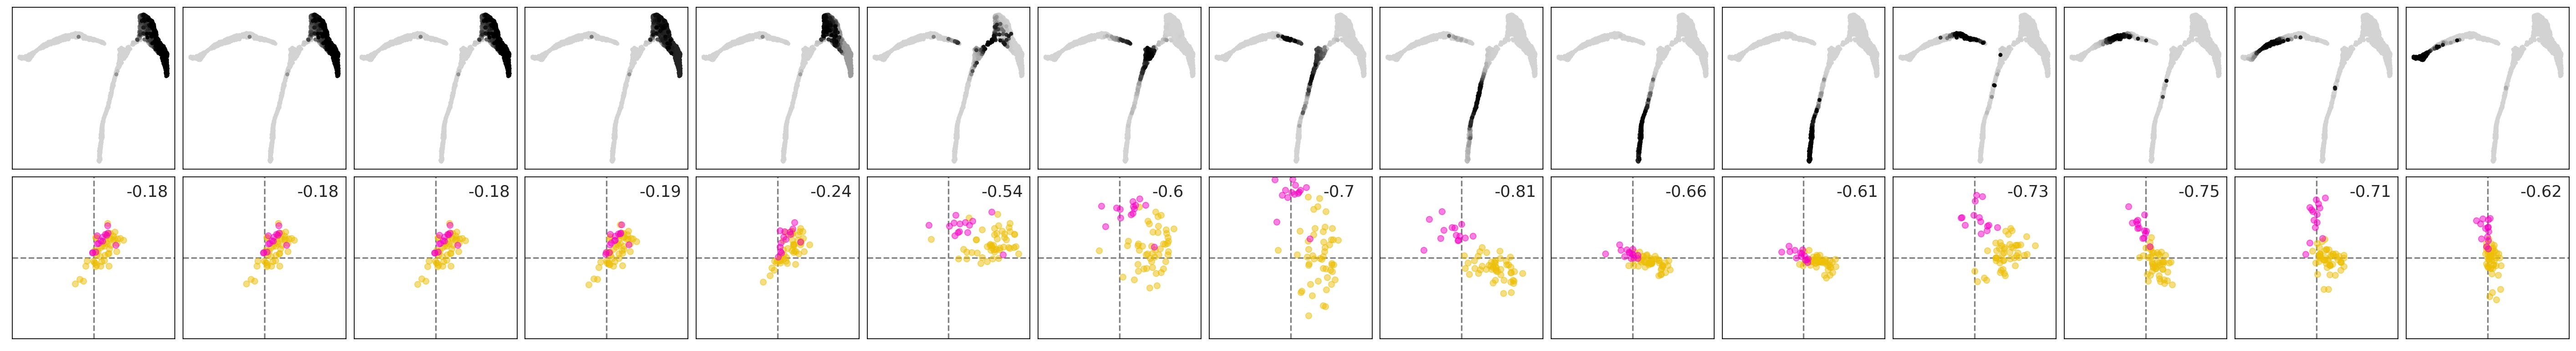

In [38]:
scf.pl.slide_cors(adata,root_milestone=root_mil,milestones=miles,
                 save="-Bif_SA_Glia.png")

In [39]:
scf.tl.synchro_path(adata,root_milestone=root_mil,milestones=miles,winp=20,w=150,step=10)

computing local correlations
    finished (0:00:07) --> added 
    'ecaNCC->Gut_glia<>bi_ChC_Symp/synchro', mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules (adata.uns)
    'inter_cor ecaNCC->Gut_glia<>bi_ChC_Symp', loess fit of inter-module mean local gene-gene correlations prior to bifurcation (adata.obs)


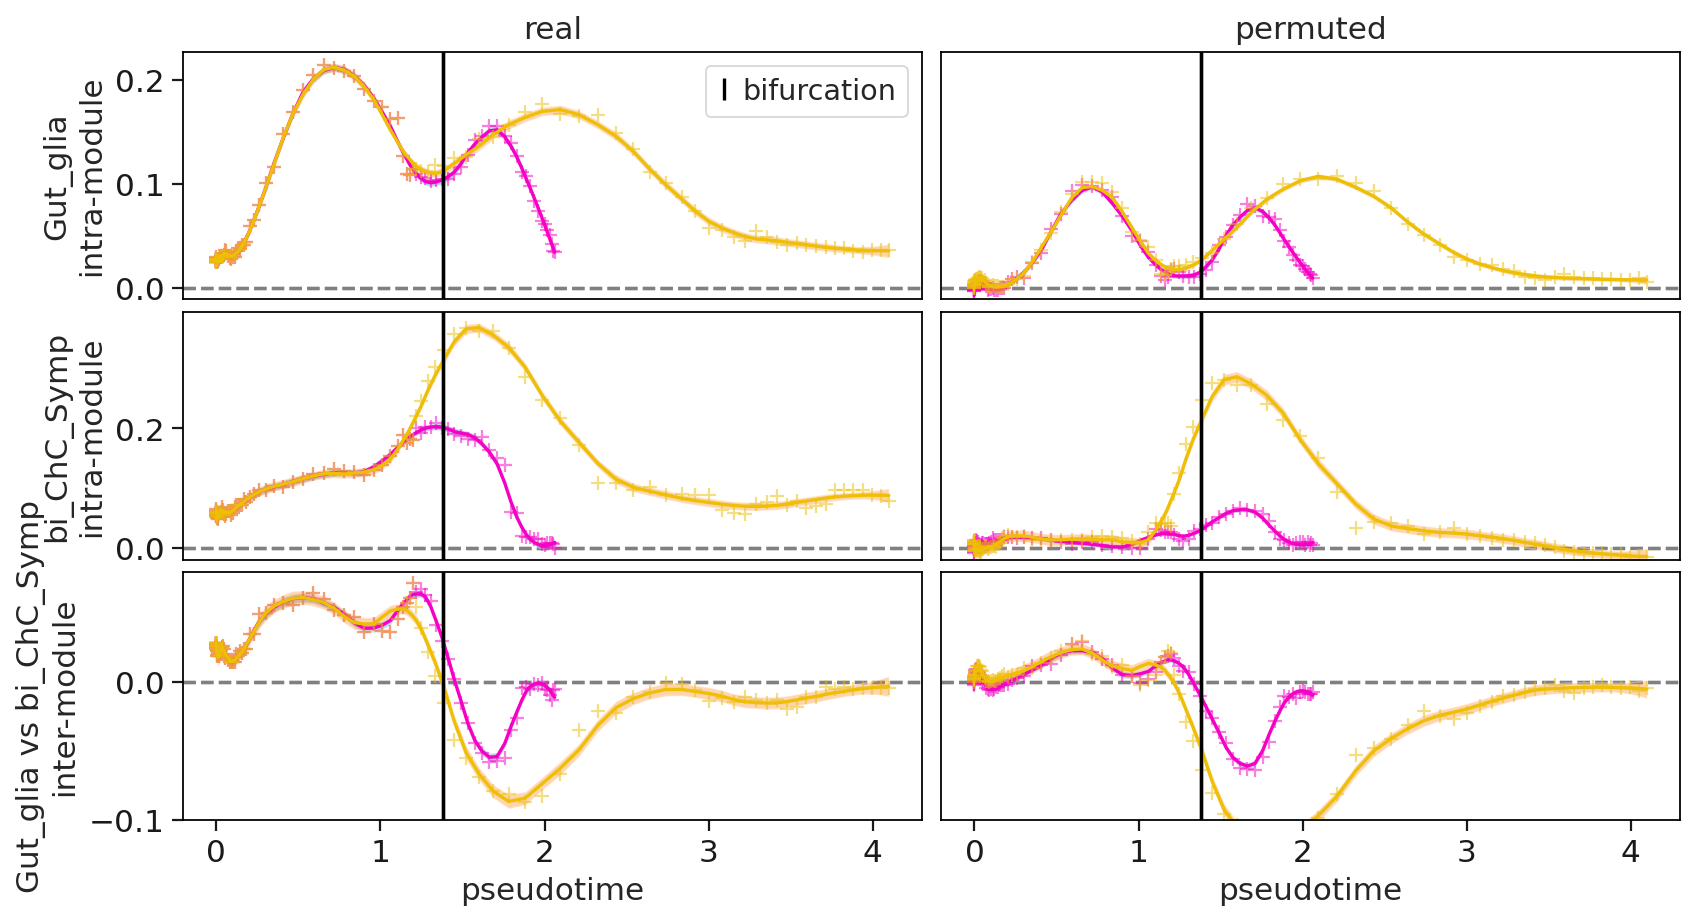

In [40]:
scf.pl.synchro_path(adata,root_milestone=root_mil,milestones=miles,
                   save="Bif_SA_Glia.png")

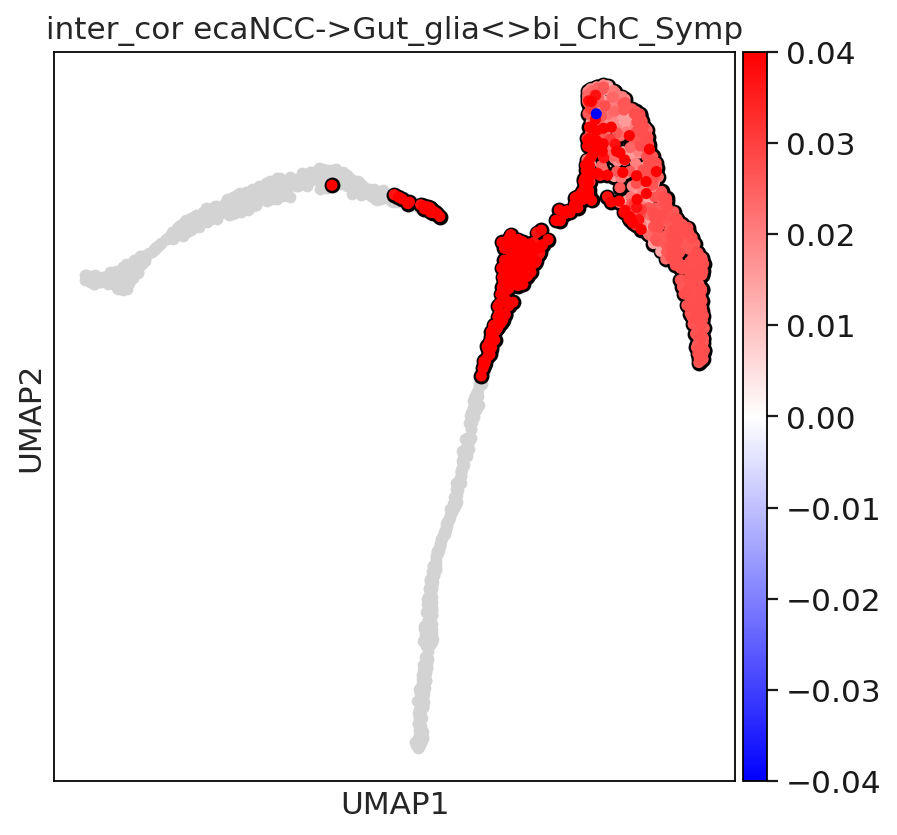

In [41]:
import matplotlib.pyplot as plt
import numpy as np
nm="inter_cor "+root_mil+"->"+miles[0]+"<>"+miles[1]
fig, ax = plt.subplots()
ax.scatter(adata.obsm["X_umap"][:,0],adata.obsm["X_umap"][:,1],color="lightgrey",s=20)
ax.scatter(adata[~np.isnan(adata.obs[nm]),].obsm["X_umap"][:,0],
           adata[~np.isnan(adata.obs[nm]),].obsm["X_umap"][:,1],
           color="black",s=40)
sc.pl.umap(adata[adata.obs[nm].abs().sort_values().index,],show=False,
           color=nm,vmin=-0.04,vmax=0.04,color_map="bwr",ax=ax,s=100,sort_order=False)
plt.savefig("figures/"+nm+".png")